Training PG-RL...
Evaluating PG-RL...


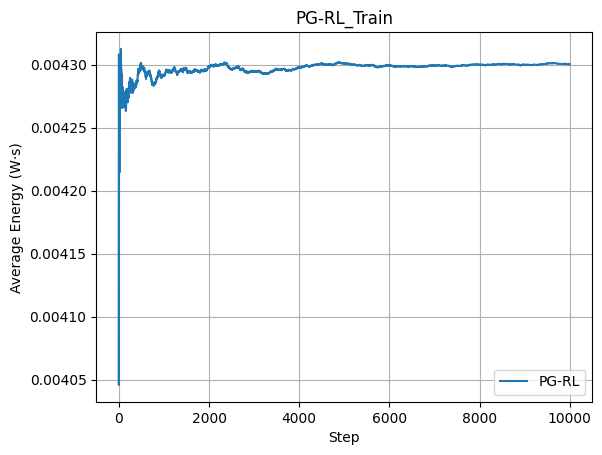

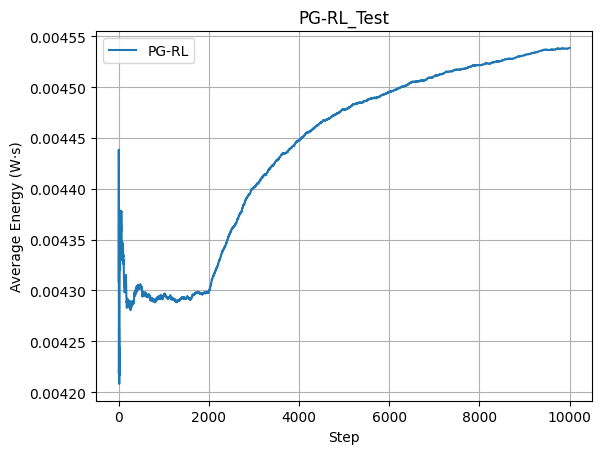

In [4]:
# Comparison of Lyapunov, PG-RL, and Lifelong PG-RL with GPU Support
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import Lasso
from sklearn.preprocessing import normalize
import time
import pandas as pd

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------- Environment ----------------------------
class WSNEnvFixed:
    def __init__(self):
        self.NumberTxs = 2
        self.Bandwidth = 5e6
        self.NoisePowerWatt = 10**(-120 / 10) / 1000
        self.Tx0MaxPowerWatt = 0.03
        self.BatteryCapacityJoul = 0.1
        self.ArrivalDataRate = 5
        self.ComChannScale = 1.0
        self.EHChannScale = 1.0
        self.EHPowerConversionEffi = 0.1
        self.reset()

    def reset(self):
        self.queues = np.zeros(self.NumberTxs)
        self.batteries = np.zeros(self.NumberTxs - 1)
        self.CommChannGain = np.random.rayleigh(scale=self.ComChannScale, size=self.NumberTxs)
        self.EHChannGain = np.random.rayleigh(scale=self.EHChannScale, size=1)
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.queues, self.batteries, self.CommChannGain, self.EHChannGain])

    def step(self, action):
        Tx0Power, Tx0CommTime, Tx1CommTime, EHTime = action
        Arrivals = np.random.poisson(self.ArrivalDataRate, self.NumberTxs)
        Tx0TransmitData = self.Bandwidth * np.log2(1 + (Tx0Power * self.CommChannGain[0]) / self.NoisePowerWatt) * Tx0CommTime
        Tx0TransmitData = float(min(Tx0TransmitData, self.queues[0]))
        Tx1Power = (self.batteries / EHTime).item()
        Tx1Rate = self.Bandwidth * np.log2(1 + (Tx1Power * self.CommChannGain[1]) / self.NoisePowerWatt)
        Tx1TransmitData = float(min(Tx1Rate * Tx1CommTime, self.queues[1]))
        HarvestedPow = self.EHPowerConversionEffi * (self.Tx0MaxPowerWatt - Tx0Power) * self.EHChannGain
        self.queues = np.maximum(self.queues - np.array([Tx0TransmitData, Tx1TransmitData]), 0) + Arrivals
        self.batteries = np.maximum(self.batteries - (Tx1Power * Tx1CommTime), 0) + (HarvestedPow * EHTime)
        self.CommChannGain = np.random.rayleigh(scale=self.ComChannScale, size=self.NumberTxs)
        self.EHChannGain = np.random.rayleigh(scale=self.EHChannScale, size=1)
        energy = (Tx0Power * Tx0CommTime) + (Tx1Power * Tx1CommTime)
        reward = -energy
        return self._get_state(), reward, False, Tx0Power, Tx0CommTime, Tx1Power, Tx1CommTime

class WSNEnv(WSNEnvFixed):
    def update_conditions(self, step):
        if step == 2000:
            self.EHChannScale = 2.0
            self.EHPowerConversionEffi = 0.2


class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# ------------------------ PG-RL & Utility --------------------------
def train_policy(env, policy_net, optimizer, episodes):
    energy_trace = []
    for step in range(episodes):
        state = env.reset()
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
        action = policy_net(state_tensor).detach().cpu().numpy()

        Tx0Power = action[0] * env.Tx0MaxPowerWatt
        time_split = action[1:] / np.sum(action[1:])
        Tx0CommTime, EHTime, Tx1CommTime = time_split
        action_vec = [Tx0Power, Tx0CommTime, Tx1CommTime, EHTime]
        _, reward, _, Tx0Power, Tx0CommTime, Tx1Power, Tx1CommTime = env.step(action_vec)
        energy = Tx0Power * Tx0CommTime + Tx1Power * Tx1CommTime
        energy_trace.append(energy)

        optimizer.zero_grad()
        output = policy_net(state_tensor)
        target = torch.tensor(action, dtype=torch.float32, device=device)
        loss = -((output - target) ** 2).mean() * reward
        loss.backward()
        optimizer.step()
    return energy_trace


def evaluate_policy(env, policy_net, steps):
    energy_trace = []
    for step in range(steps):
        env.update_conditions(step)
        state = env.reset()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        with torch.no_grad():
            action = policy_net(state_tensor).detach().cpu().numpy()
        Tx0Power = action[0] * env.Tx0MaxPowerWatt
        time_split = action[1:] / np.sum(action[1:])
        Tx0CommTime, EHTime, Tx1CommTime = time_split
        action_vec = [Tx0Power, Tx0CommTime, Tx1CommTime, EHTime]
        _, _, _, Tx0Power, Tx0CommTime, Tx1Power, Tx1CommTime = env.step(action_vec)
        energy = Tx0Power * Tx0CommTime + Tx1Power * Tx1CommTime
        energy_trace.append(energy)
    return energy_trace

    
if __name__ == "__main__":
    steps = 10000

    print("Training PG-RL...")
    env_train = WSNEnvFixed()
    policy_net = PolicyNet(6, 4).to(device)
    optimizer = optim.Adam(policy_net.parameters(), lr=0.01)
    energy_pg_train = train_policy(env_train, policy_net, optimizer, episodes=steps)
    

    print("Evaluating PG-RL...")
    env_eval_pg = WSNEnv()
    energy_pg_test = evaluate_policy(env_eval_pg, policy_net.to(device), steps)

    plt.figure()
    plt.plot(np.cumsum(energy_pg_train)/np.arange(1, steps+1), label="PG-RL")
    plt.title("PG-RL_Train")
    plt.xlabel("Step")
    plt.ylabel("Average Energy (W·s)")
    plt.legend()
    plt.grid(True)

    plt.figure()
    plt.plot(np.cumsum(energy_pg_test)/np.arange(1, steps+1), label="PG-RL")
    plt.title("PG-RL_Test")
    plt.xlabel("Step")
    plt.ylabel("Average Energy (W·s)")
    plt.legend()
    plt.grid(True)

    plt.show()
